 **1. DATA EXPLORATION & PREPROCESSING**


In [ ]:
!pip install yfinance # Python library to access historical market data from Yahoo Finance

1.1 DOWNLOADING DATA

The stock data for Apple (AAPL), Google (GOOG), Microsoft (MSFT), and Amazon (AMZN) was collected using the yfinance library. This data included information such as the opening price, closing price, high, low, adjusted closing price, and trading volume. The time range for data collection was set to the previous year from the current date.

In [ ]:
import yfinance as yf
from datetime import datetime

# Set start and end dates for the data
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# Download stock data for AAPL, GOOG, MSFT, AMZN
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
for stock in tech_list:
    globals()[stock] = yf.download(stock, start=start, end=end)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1.2 CONCATENATION OF DATA

To handle data from multiple companies efficiently, the individual stock data for each company was concatenated into a single DataFrame. A new column, company_name, was added to differentiate between the stocks.

In [ ]:
# Combine stock data into a single DataFrame
import pandas as pd
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-09-30,187.139999,188.490005,184.649994,186.330002,186.330002,41583900,AMAZON
2024-10-01,184.899994,186.190002,183.449997,185.130005,185.130005,36044900,AMAZON
2024-10-02,184.440002,186.600006,184.039993,184.759995,184.759995,23704100,AMAZON
2024-10-03,183.050003,183.440002,180.880005,181.960007,181.960007,30204300,AMAZON
2024-10-04,185.750000,187.600006,183.600006,186.509995,186.509995,40890300,AMAZON
2024-10-07,182.949997,183.600006,180.250000,180.800003,180.800003,42364200,AMAZON
2024-10-08,181.919998,183.089996,180.919998,182.720001,182.720001,26372100,AMAZON
2024-10-09,182.820007,185.850006,182.050003,185.169998,185.169998,26343100,AMAZON
2024-10-10,187.130005,188.130005,185.830002,186.649994,186.649994,27785000,AMAZON


**DATA PREPROCESSING**

1.3 Handling Missing Values

The stock market data may contain missing values due to holidays or non-trading days. Missing values were handled by forward-filling, which is appropriate in this case as stock prices are time-sequential, and missing values can be inferred from previous days.

In [ ]:
df.isnull().sum() # To check if there are any missing values in the data

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
company_name,0


There are no missing values.

In [ ]:
# Forward-fill any missing values in the data
df.ffill(inplace=True)
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
company_name,0


1.4 Removing duplicates

In [ ]:
df.duplicated().sum() # To check if there are any duplicate values


0

1.5 Normalization and Scaling

Since the LSTM model is sensitive to large variations in input data, it was necessary to scale the stock prices before feeding them into the model. The MinMaxScaler from sklearn.preprocessing was used to scale the data between 0 and 1, a common practice for time-series prediction tasks.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Prepare the close price data for scaling
data = df.filter(['Close'])
dataset = data.values

# Scale data to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


- Scaling only the 'Close' price ensures the model focuses on predicting the target variable (future stock prices) without altering the inherent relationships in other features like volume or moving averages.
- Scaling all features could distort their relative importance or patterns, whereas scaling only the target feature maintains its interpretability and ensures the model's focus remains on stock price prediction.


**2. EXPLORATORY DATA ANALYSIS (EDA)**

2.1 Descriptive Statistics and Data Summary

In [ ]:
AAPL.describe() # Summary statistics for AAPL stock

,Open,High,Low,Close,Adj Close,Volume
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,195.923824,197.696295,194.234781,196.071355,195.654595,5.901275e+07
std,20.550804,20.776775,20.121895,20.514640,20.707137,3.002735e+07
min,165.350006,166.399994,164.080002,165.000000,164.585999,2.404830e+07
25%,181.185005,182.505005,179.389999,181.169998,180.600266,4.375595e+07
50%,190.759995,191.919998,189.399994,190.639999,190.069992,5.251700e+07
75%,217.255005,219.854996,215.350006,217.745003,217.619003,6.515995e+07
max,236.479996,237.229996,233.089996,234.820007,234.548523,3.186799e+08


In [ ]:
AAPL.info() # Data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2023-10-13 to 2024-10-11
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          251 non-null    float64
 1   High          251 non-null    float64
 2   Low           251 non-null    float64
 3   Close         251 non-null    float64
 4   Adj Close     251 non-null    float64
 5   Volume        251 non-null    int64  
 6   company_name  251 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.7+ KB


In [ ]:
AAPL.dtypes  # Data types for columns

,0
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64
company_name,object


2.2 Plotting Closing Prices

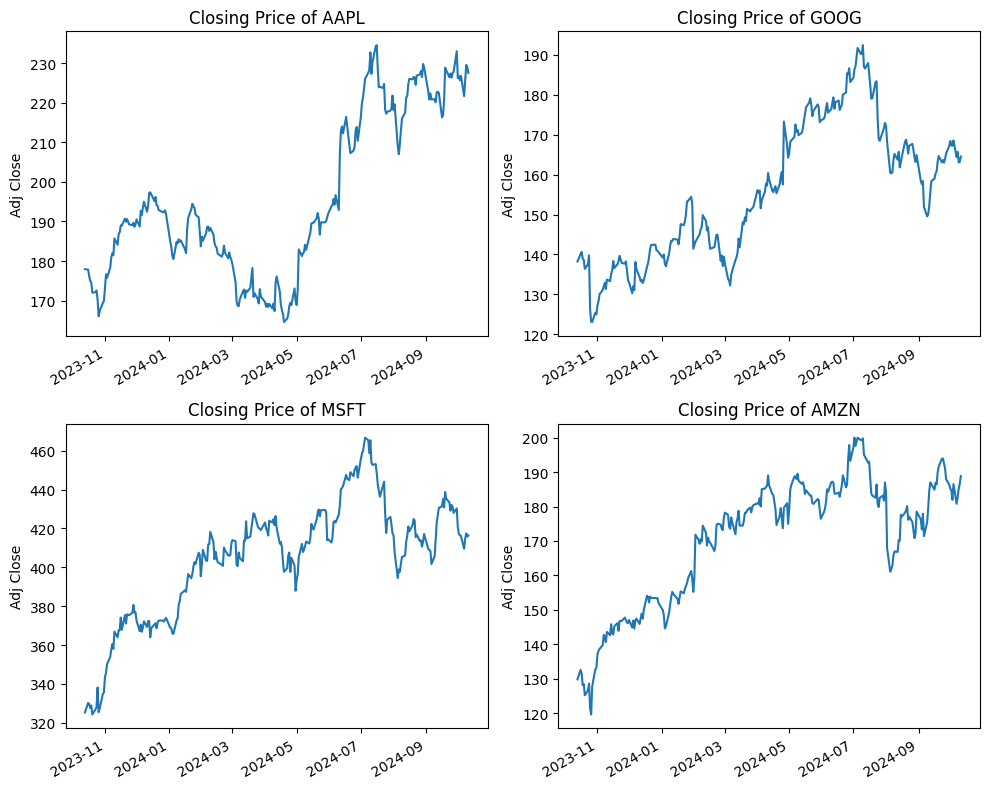

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")

plt.tight_layout()

2.3 FEATURE ENGINEERING

Several features were created to aid in the analysis and modeling of stock prices:

Moving Averages: To capture trends, moving averages for 10, 20, and 50 days were calculated and added as new columns.

Daily Return: The percentage change in closing prices from day to day was calculated to gauge stock volatility and trends.

In [ ]:
# Create moving averages and daily return
# 10-day MA: A short-term trend indicator.
# 20-day MA: A medium-term trend indicator.
# 50-day MA: A long-term trend indicator, showing the overall direction of the stock.


# Calculate moving averages
ma_day = [10, 20, 50]
for ma in ma_day:
    for company in company_list:
        company[f"MA for {ma} days"] = company['Adj Close'].rolling(ma).mean()

# Calculate daily returns
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Concatenate the updated DataFrames into one
df = pd.concat(company_list, axis=0)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,company_name,MA for 10 days,MA for 20 days,MA for 50 days,Daily Return
Date,,,,,,,,,,,
2024-10-07,182.949997,183.600006,180.250000,180.800003,180.800003,42364200,AMAZON,187.111002,187.111002,179.220001,-0.030615
2024-10-08,181.919998,183.089996,180.919998,182.720001,182.720001,26372100,AMAZON,185.987001,187.269501,179.210401,0.010619
2024-10-09,182.820007,185.850006,182.050003,185.169998,185.169998,26343100,AMAZON,185.251001,187.302001,179.279601,0.013408
2024-10-10,187.130005,188.130005,185.830002,186.649994,186.649994,27785000,AMAZON,184.800000,187.284501,179.273000,0.007993
2024-10-11,186.630005,189.929993,186.300003,188.820007,188.820007,25658900,AMAZON,184.885001,187.401001,179.368000,0.011626



- Moving Averages (MAs) are a popular statistical tool used in time-series analysis, particularly in financial markets, to smooth out short-term fluctuations and highlight longer-term trends or cycles. By averaging the data points of a stock price over a specific time period, MAs provide insight into the general direction the stock is moving.

Formula for SMA:

𝑆
𝑀
𝐴
=
(𝑃
1
+
𝑃
2
+
.
.
.
+
𝑃
𝑛)
/ n
​

**Moving Average Crossovers:
When a short-term MA (e.g., 10-day) crosses above a long-term MA (e.g., 50-day), it indicates a bullish signal (buy). Conversely, when it crosses below, it's a bearish signal (sell).

- Daily returns represent the percentage change in the stock's adjusted closing price from one trading day to the next. This calculation helps in understanding the short-term performance of the stock and its volatility. The formula for daily return is:

Daily Return
=
( (
Price
t/ price t-1) - 1)



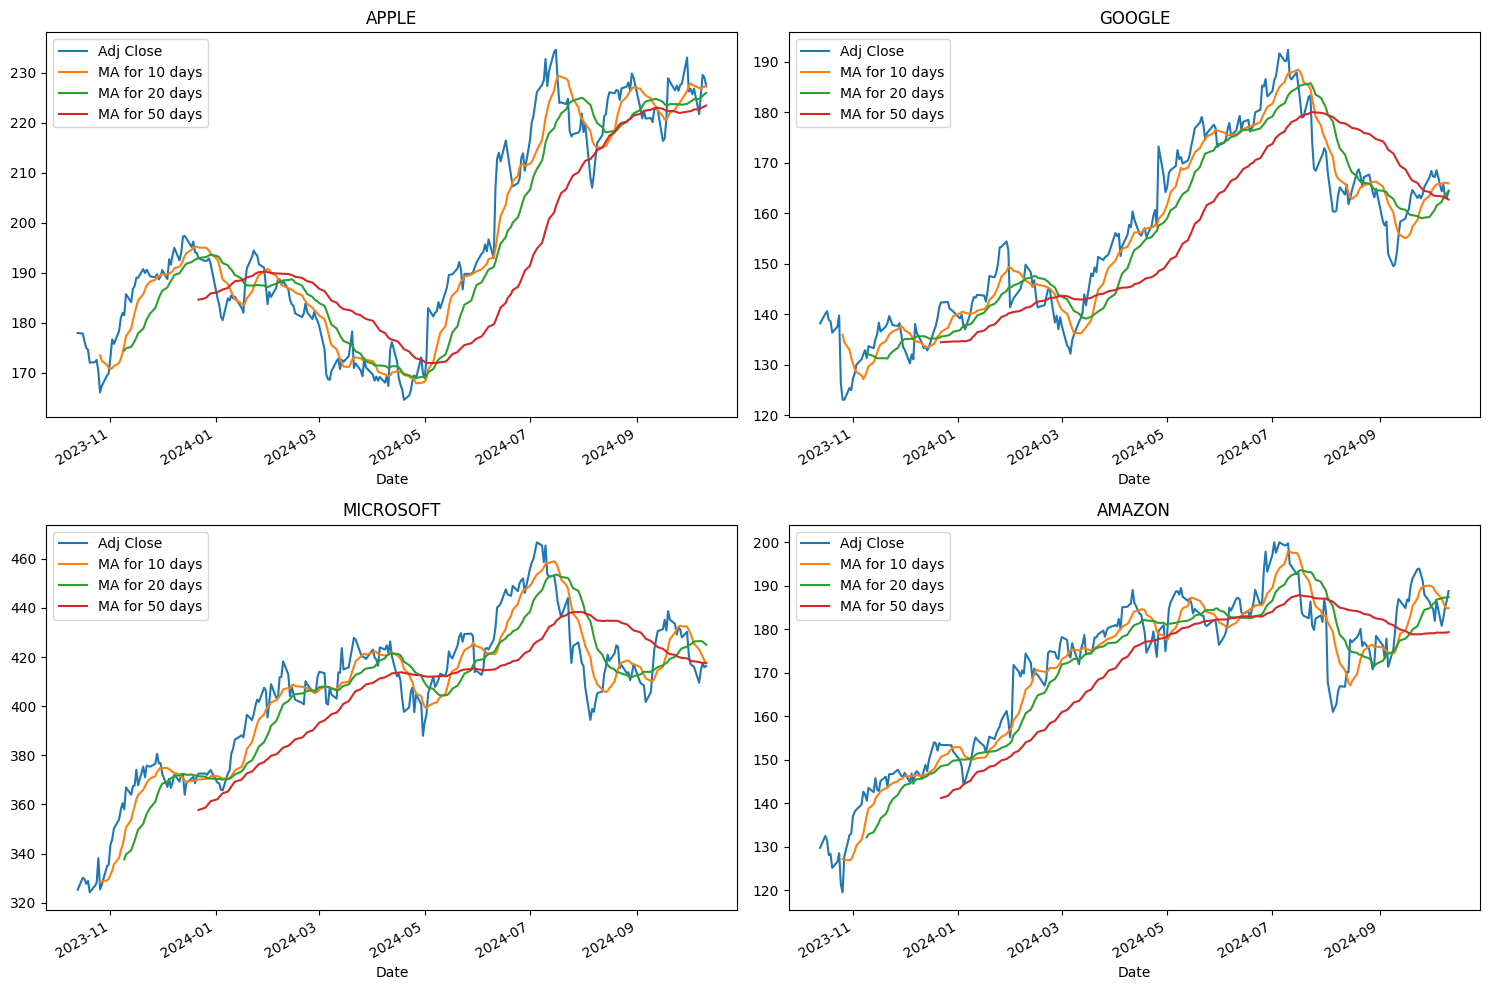

In [ ]:
# Plot the moving averages
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

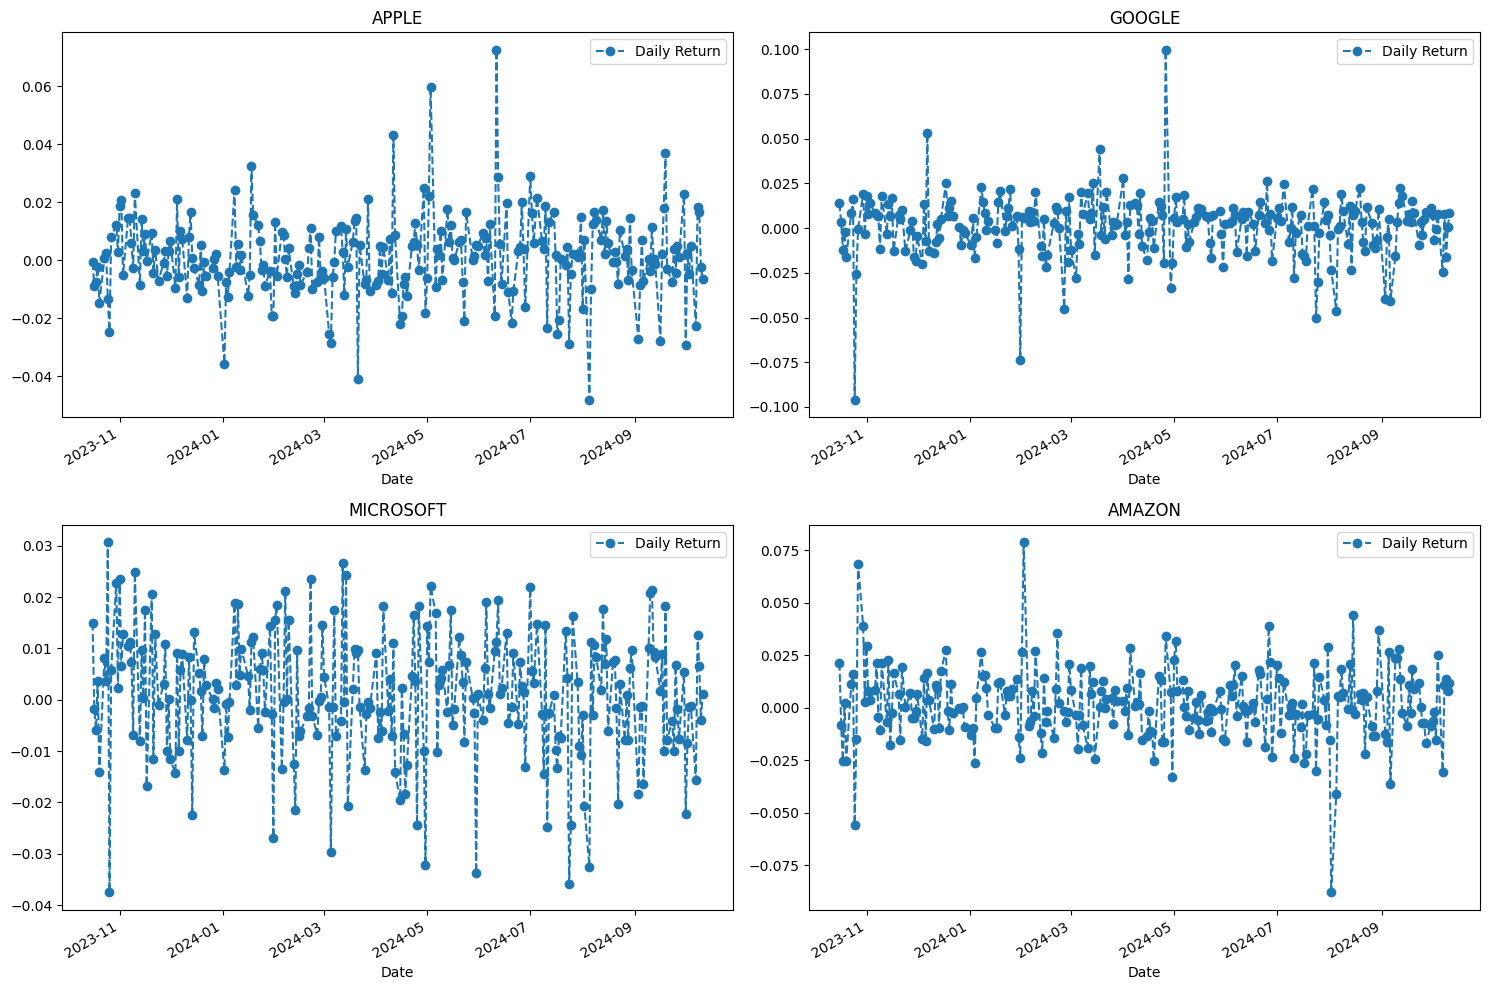

In [ ]:
# Plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

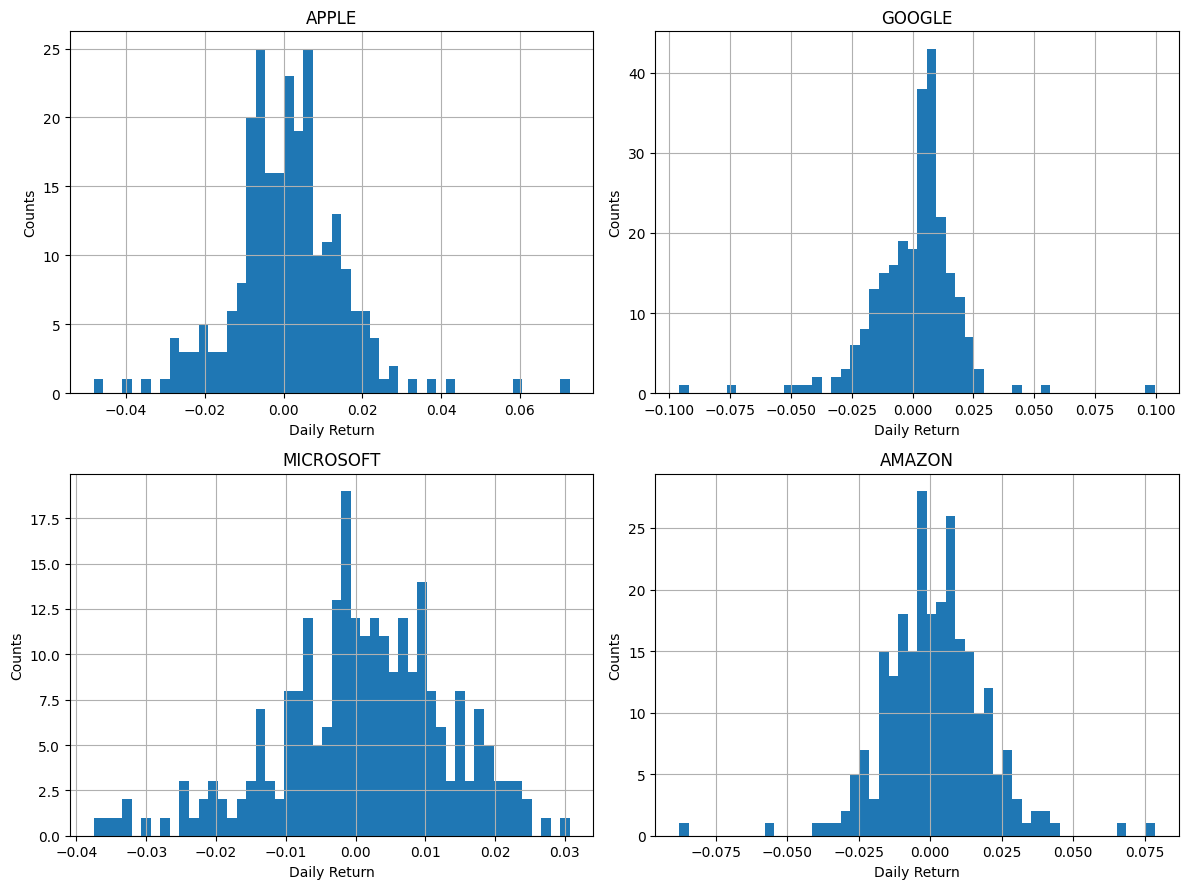

In [ ]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')

plt.tight_layout()

2.4 Correlation Analysis

In [ ]:
closing_df = yf.download(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2023-10-13 00:00:00+00:00,NaN,NaN,NaN,NaN
2023-10-16 00:00:00+00:00,-0.000727,0.021265,0.013783,0.014982
2023-10-17 00:00:00+00:00,-0.008785,-0.008148,0.003559,-0.001744
2023-10-18 00:00:00+00:00,-0.007395,-0.025405,-0.012129,-0.005872
2023-10-19 00:00:00+00:00,-0.002161,0.002107,-0.002154,0.003665


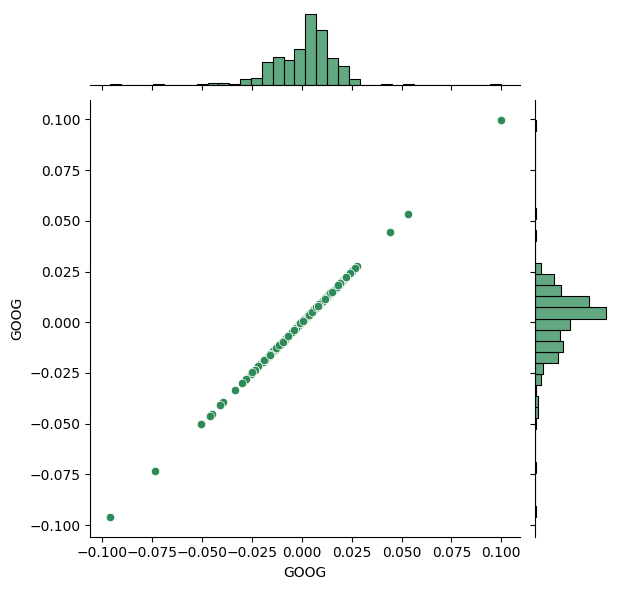

In [ ]:
import seaborn as sns
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

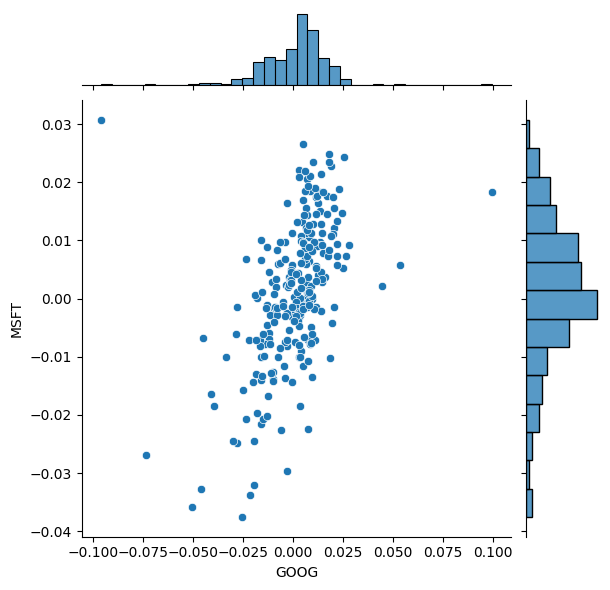

In [ ]:
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

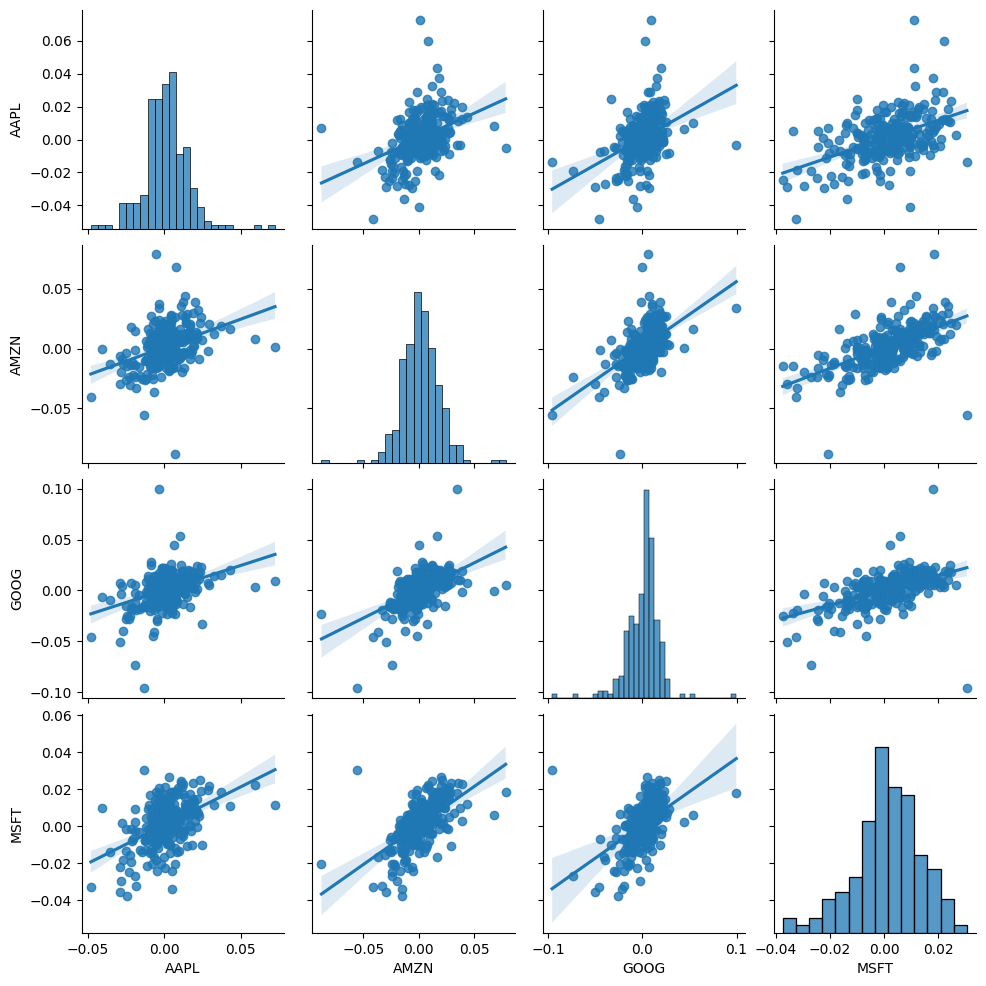

In [ ]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis
# of all the comparisons

sns.pairplot(tech_rets, kind='reg')

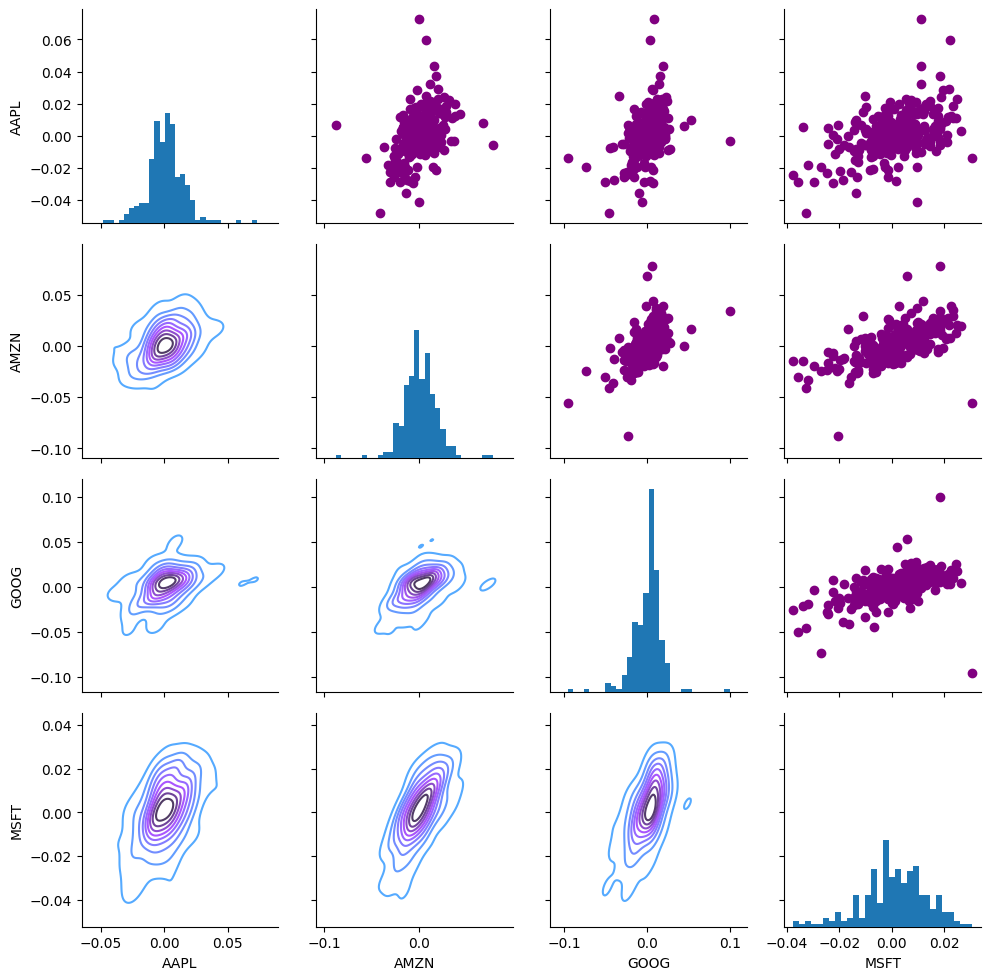

In [ ]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde)
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

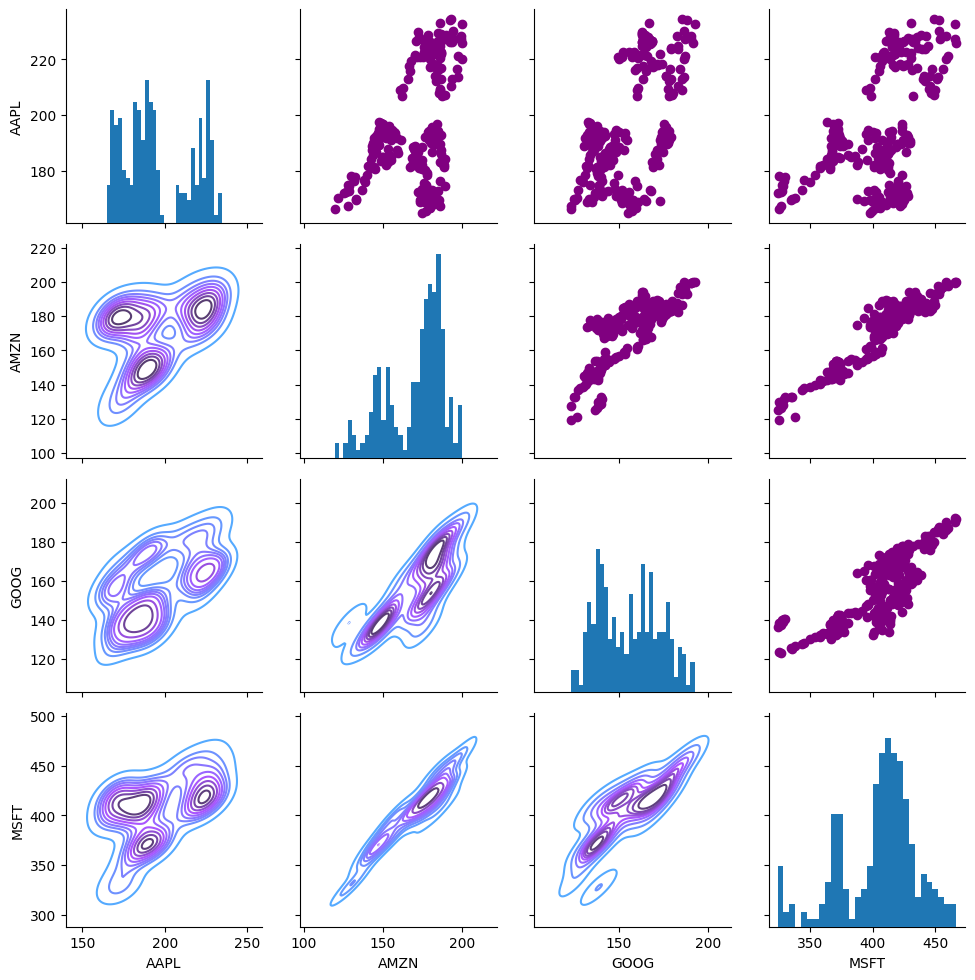

In [ ]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

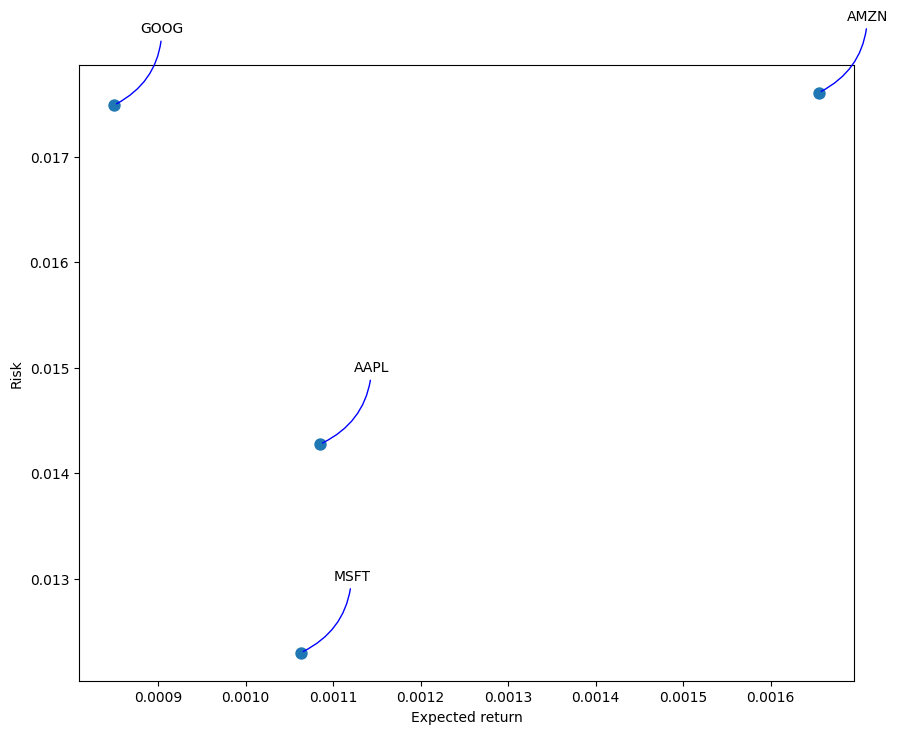

In [ ]:
import numpy as np
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

Text(0.5, 1.0, 'Correlation of stock closing price')

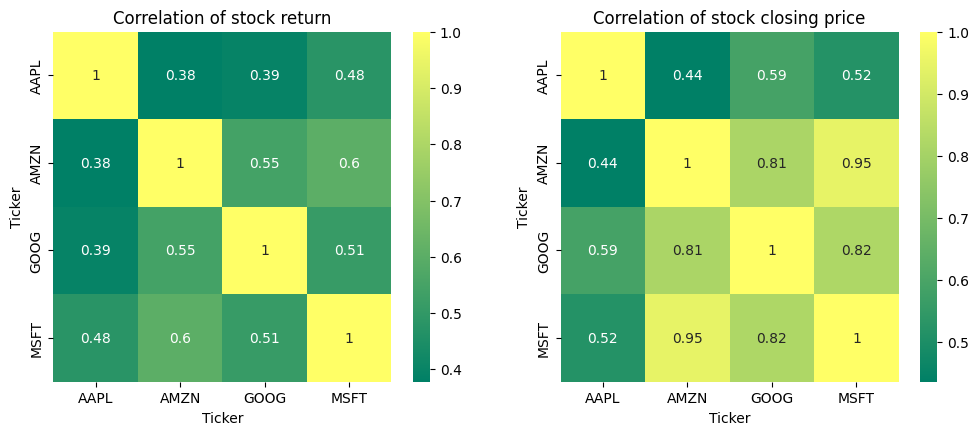

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

This Data Preprocessing and EDA stage ensures that the stock price data is clean, consistent, and suitable for use in machine learning models, particularly for time-series forecasting using LSTMs.

6. Train-Test Split

To build a reliable LSTM model, the dataset was split into training and testing sets. 95% of the data was used for training the model, while the remaining 5% was reserved for testing and evaluation.

In [ ]:
import numpy as np

# Split the data into training and testing sets
training_data_len = int(np.ceil(len(dataset) * .95))

# Create the training dataset
train_data = scaled_data[0:training_data_len]


7. Sequence Creation for LSTM Model
- In the context of stock price prediction, sequence creation refers to structuring the data into fixed-length sequences where each sequence consists of a specific number of past observations (time steps) used to predict a future value.

- Since LSTMs are designed to work with sequential data, the training set was further transformed into sequences of 60 time steps. Each sequence consisted of the stock prices for the previous 60 days, which were used to predict the stock price on the 61st day.

In [ ]:
# Create sequences for training the LSTM model
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert to numpy arrays and reshape for LSTM input
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
